### A starting notebook for 2-d diffusion problems

In this package we seek to solve various 2-d diffusion problems

In [1]:
using Pkg
Pkg.activate("/Users/jeff/Dropbox/MAE250H/julia/HW4")

"/Users/jeff/Dropbox/MAE250H/julia/development/HW4/Project.toml"

The usual set of notebooks

In [2]:
using Revise
using Plots
using LinearAlgebra
using HW4

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.1/HW4/enQ9F.ji for HW4 [59be1dea-6512-11e9-2444-99050c21919d]
└ @ Base loading.jl:1184


### Problem statement

The goal of this problem is to solve

$$ \dfrac{\partial u}{\partial t} = \nu \nabla^2 u$$

on a square domain $x, y \in [0,L]$ subject to Dirichlet boundary conditions $u(0,y,t) = u_L(y)$ and $u(L,y,t) = u_R(y)$, $u(x,0,t) = u_B(x)$, $u(x,L,t) = u_T(x)$, and initial condition $u(x,y,0) = 0$.

### Functions that evaluate the diffusion problem

#### Function that introduces Dirichlet boundary conditions into provided data

In [3]:
# This function takes as input a set of edge data and returns the same
# data with the boundary and ghost values set as needed to enforce Dirichlet
# boundary conditions.
function apply_bc!(u::EdgeData{NX,NY},t::Real) where {NX,NY}
    i_x, i_y = indices(u,1,interior=true)
    j_x, j_y = indices(u,2,interior=true)
    
    # on left, right sides, set x edges directly
    y = yedgex.(j_x)
    u.qx[1,   j_x] .= uL.(y,t)
    u.qx[NX+1,j_x] .= uR.(y,t)
    
    # on bottom, top sides, set x edges via averaging with ghost edges
    x = xedgex.(i_x)
    u.qx[i_x,1]    .= -u.qx[i_x,2]    .+ 2*uB.(x,t)
    u.qx[i_x,NY+2] .= -u.qx[i_x,NY+1] .+ 2*uT.(x,t)
    
    # on left, right sides, set y edges via averaging with ghost edges
    y = yedgey.(j_y)
    u.qy[1,   j_y] .= -u.qy[2,   j_y] .+ 2*vL.(y,t)
    u.qy[NX+2,j_y] .= -u.qy[NX+1,j_y] .+ 2*vR.(y,t)
    
    # on bottom, top sides, set y edges directly
    x = xedgey.(i_y)
    u.qy[i_y,1]    .= vB.(x,t)
    u.qy[i_y,NY+1] .= vT.(x,t)
    
    return u
end

# For use on node data
function apply_bc!(u::NodeData{NX,NY},t::Real) where {NX,NY}
    i_n = indices(u,1)
    j_n = indices(u,2)
    
    # on left, right sides, set x edges directly
    y = ynode.(j_n)
    u[1,   j_n] .= uL.(y,t)
    u[NX+1,j_n] .= uR.(y,t)
    
    # on bottom, top sides, set x edges via averaging with ghost edges
    x = xnode.(i_n)
    u[i_n,1]    .= uB.(x,t)
    u[i_n,NY+1] .= uT.(x,t)
    
    return u
end

# For use on cell data
function apply_bc!(u::CellData{NX,NY},t::Real) where {NX,NY}
    i_c = indices(u,1)
    j_c = indices(u,2)
    
    # on left, right sides, set x edges directly
    y = ycell.(j_c)
    u[1,   j_c] .= -u[2,   j_c] .+ 2*uL.(y,t)
    u[NX+2,j_c] .= -u[NX+1,j_c] .+ 2*uR.(y,t)
    
    # on bottom, top sides, set x edges via averaging with ghost edges
    x = xcell.(i_c)
    u[i_c,1]    .= -u[i_c,2]    .+ 2*uB.(x,t)
    u[i_c,NY+2] .= -u[i_c,NY+1] .+ 2*uT.(x,t)
    
    return u
end

apply_bc! (generic function with 3 methods)

#### Set up the right-hand side function, to be used for R-K time marching

In [4]:
# RHS function of diffusion problem for edge data
function diffuse2d_dirichlet(u::EdgeData{NX,NY},t::Real) where {NX,NY}
    du = EdgeData(u)
    
    # set boundary values to Dirichlet values before applying Laplacian
    apply_bc!(u,t)
    
    du = laplacian(u)
    
    return ν/Δx^2*du
end

# RHS function of diffusion problem for node data
function diffuse2d_dirichlet(u::NodeData{NX,NY},t::Real) where {NX,NY}
    du = NodeData(u)
    
    # set boundary values to Dirichlet values before applying Laplacian
    apply_bc!(u,t)
    
    du = laplacian(u)
    
    return ν/Δx^2*du
end

diffuse2d_dirichlet (generic function with 2 methods)

#### Construct the Crank-Nicolson function for advancement by one step.

In [6]:
# Crank-Nicolson function of diffusion problem for edge data
function diffuse2d_dirichlet_cn(t::Real,u::EdgeData{NX,NY}) where {NX,NY}
    
    # parameters needed
    # ν, Δt, Δx, bcs
    
    i_x, i_y = indices(u,1)
    j_x, j_y = indices(u,2)
    
    # calculate the grid Fourier number
    Fo = ν*Δt/Δx^2
    
    # This will hold the right-hand side at first, but ultimately hold
    # the solution
    unp1 = deepcopy(u)
    
    # Apply the factorized rhs operator, after setting the
    # current boundary values in u
    apply_bc!(u,t)
    unp1 .+= 0.5Fo*laplacian(u,1)  # (I + 0.5*Fo*L_x)
    unp1 .+= 0.5Fo*laplacian(unp1,2) # (I + 0.5*Fo*L_y)
    
    # Now apply the boundary conditions at t+Δt. For this, we set up
    # blank edge data and then apply the boundary conditions to the
    # ghosts, boundaries
    ubc   = EdgeData(u)
    apply_bc!(ubc,t+Δt)
    unp1 .+= 0.5Fo*laplacian(ubc)

    #=
    now unp1 holds the right-hand side. Now set up the tridiagonal
    solution, first in the x direction, then in the y direction
    =#
    
    #= Solve (I - 0.5*Fo*L_x)u^(n+1/2) = b in each row =#
    
    # Tridiagonal coefficients for x edge data
    axlap, bxlap, cxlap = 1,-2,1
    ax, bx, cx = -0.5Fo*axlap, 1-0.5Fo*bxlap, -0.5Fo*cxlap
    
    # Tridiagonal coefficients for y edge data
    aylap, bylap, cylap = 1*ones(NX-1), -2*ones(NX), 1*ones(NX-1)
    # adjust the diagonal values in the first and last entry (-2 -> -3)
    bylap[1] -= 1
    bylap[NX] -= 1
    ay, by, cy = -0.5Fo*aylap, 1 .- 0.5Fo*bylap, -0.5Fo*cylap
     
    # Solve in each row
    for j in j_x # Loop through the interior x edge rows
        unp1.qx[i_x,j] .= trisolve(ax,bx,cx,unp1.qx[i_x,j],"regular")
    end
    for j in j_y # Loop through the interior y edge rows
        unp1.qy[i_y,j] .= trisolve(ay,by,cy,unp1.qy[i_y,j],"regular")
    end
    
    # now unp1 contains the solution u^(n+1/2). This
    # supplies the right-hand side in the y direction. 
    
    #= Solve (I - 0.5*Fo*L_x)u^(n+1) = u^(n+1/2) in each row =#
    
    # First, we need to transpose the data so that grid columns are
    # accessible in contiguous (column-wise) chunks
    qxtmp = deepcopy(transpose(unp1.qx))
    qytmp = deepcopy(transpose(unp1.qy))
    
    # Tridiagonal coefficients for x edge data
    axlap, bxlap, cxlap = 1*ones(NY-1), -2*ones(NY), 1*ones(NY-1)
    # adjust the diagonal values in the first and last entry (-2 -> -3)
    bxlap[1] -= 1
    bxlap[NY] -= 1
    ax, bx, cx = -0.5Fo*axlap, 1 .- 0.5Fo*bxlap, -0.5Fo*cxlap
    
    # Tridiagonal coefficients for y edge data
    aylap, bylap, cylap = 1,-2,1
    ay, by, cy = -0.5Fo*aylap, 1-0.5Fo*bylap, -0.5Fo*cylap
    
    for i in i_x # Loop through the interior x edge columns
        qxtmp[j_x,i] .= trisolve(ax,bx,cx,qxtmp[j_x,i],"regular")
    end
    for i in i_y # Loop through the interior y edge columns
        qytmp[j_y,i] .= trisolve(ay,by,cy,qytmp[j_y,i],"regular")
    end
    
    # now transpose back and place in the final edge data
    unp1.qx .= transpose(qxtmp)
    unp1.qy .= transpose(qytmp)
    
    # Finally, apply boundary values in the appropriate places
    apply_bc!(unp1,t+Δt)
    
    return t+Δt, unp1
end

diffuse2d_dirichlet_cn (generic function with 1 method)

### Set up the physical problem

In [68]:
#LX = 8  # length of x side
#x0, y0 = -4.0, -4.0  # coordinates of lower left hand corner of domain

LX = 1  # length of x side
x0, y0 = 0.0, 0.0  # coordinates of lower left hand corner of domain

(0.0, 0.0)

#### Set boundary conditions of the problem

In [69]:
ν = 1
uL(y,t) = 0.0
uR(y,t) = 0.0
uB(x,t) = 0.0
uT(x,t) = 1*sin(π*x)

vL(y,t) = 0.0
vR(y,t) = 0.0
vB(x,t) = 0.0
vT(x,t) = 0*sin(π*x)

vT (generic function with 1 method)

Set up function that evaluates the initial condition of a Gaussian pulse.

In [70]:
σ = 0.3 # width of pulse
A = 0 # strength
f(x,y,σ) = A/(π*σ^2)*exp(-(x^2+y^2)/σ^2)

f (generic function with 1 method)

### Set up the grid and associated mappings and indexing

Set up these arrays to be filled in the error data later

In [10]:
errarray = []
Narray = [] 

0-element Array{Any,1}

Number of cells in each direction

In [71]:
NX = 64
NY = 64

64

Set up the grid mappings

In [72]:
Δx = LX/NX
xnode(i_n) = x0 + (i_n - 1)*Δx
ynode(j_n) = y0 + (j_n - 1)*Δx
xcell(i_c) = x0 + (i_c - 1.5)*Δx
ycell(j_c) = y0 + (j_c - 1.5)*Δx
xedgex(i_e) = xnode(i_e) # x component of x edge
yedgex(j_e) = ycell(j_e) # y component of x edge
xedgey(i_e) = xcell(i_e) # x component of y edge
yedgey(j_e) = ynode(j_e) # y component of y edge

yedgey (generic function with 1 method)

### Set up the initial condition

Edge data

In [73]:
u0 = EdgeData(NX,NY)
i_x, i_y = indices(u0,1)
j_x, j_y = indices(u0,2)
for j in j_x, i in i_x
    u0.qx[i,j] = f(xedgex(i),yedgex(j),σ)
end
for j in j_y, i in i_y
    u0.qy[i,j] = f(xedgey(i),yedgey(j),σ)
end

Or.... Node data

In [53]:
#u0 = NodeData(NX,NY)
#i_n = indices(u0,1)
#j_n = indices(u0,2)
#for j in j_n, i in i_n
#    u0[i,j] = f(xnode(i),ynode(j),σ)
#end

#### Plot initial condition, just to be safe

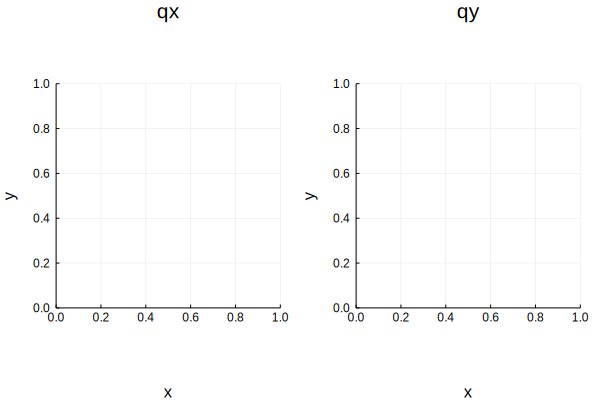

In [74]:
p1 = contour(xedgex.(i_x),yedgex.(j_x),transpose(u0.qx[i_x,j_x]),legend=false,title="qx")
p2 = contour(xedgey.(i_y),yedgey.(j_y),transpose(u0.qy[i_y,j_y]),legend=false,title="qy")
plot(p1,p2,layout=(1,2),xlabel="x",ylabel="y",ratio=1,xlim=(xedgex(1),xedgex(NX+1)),ylim=(yedgey(1),yedgey(NY+1)))

### Set up the time step and the integrator

Set up time step. Note that the maximum grid Fourier number in 2-d will be slightly smaller than in 1-d. (Why?)

In [75]:
Fo = 5 # Fourier number: this choice should be explored!
Δt = Fo*Δx^2/ν 

0.001220703125

Set the integrator. Here we are setting up a method that will take in (t,u) at one time level and return these values at the next time level:

`t, u = stepper(t,u)`

In [76]:
# For Runge-Kutta
#stepper = RK(u0,Δt,diffuse2d_dirichlet;rk=RK4)

# or, for Crank-Nicolson
stepper = diffuse2d_dirichlet_cn

diffuse2d_dirichlet_cn (generic function with 1 method)

### Solve the problem

Integrate this to final time of tf. Try different final times to explore the evolution of the problem.

In [77]:
tf = 0.1
nsteps = ceil(Int,tf/Δt)

# Initial conditions
t = 0.0
u = deepcopy(u0)

# Set up some arrays to store data
uarray = [deepcopy(u)]
tarray = [t]

# March!
for j = 1:nsteps
    global t, u = stepper(t,u)
    
    # enforce boundary conditions on result
    apply_bc!(u,t)
    
    push!(uarray,deepcopy(u))
    push!(tarray,t)
end

#### For the Gaussian pulse

Compute the exact solution at this final time level

In [45]:
texact = tarray[end]
uexact = EdgeData(u0)
i_x_b, i_y_b = indices(uexact,1,interior=false)
j_x_b, j_y_b = indices(uexact,2,interior=false)
for j in j_x_b, i in i_x_b
    uexact.qx[i,j] = f(xedgex(i),yedgex(j),sqrt(σ^2+4ν*texact))
end
for j in j_y_b, i in i_y_b
    uexact.qy[i,j] = f(xedgey(i),yedgey(j),sqrt(σ^2+4ν*texact))
end

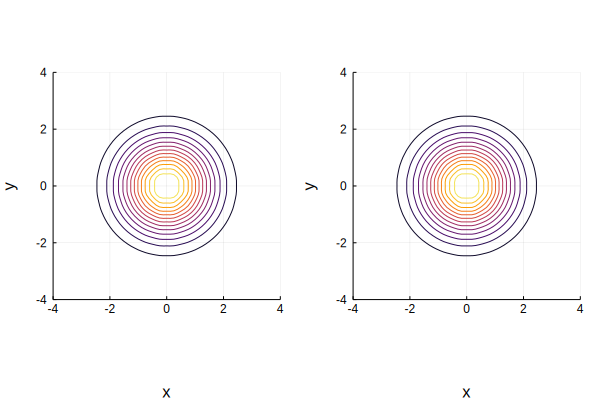

In [46]:
p1 = contour(xedgex.(i_x_b),yedgex.(j_x_b),transpose(uarray[end].qx[i_x_b,j_x_b]),legend=false)
p2 = contour(xedgey.(i_y_b),yedgey.(j_y_b),transpose(uarray[end].qy[i_y_b,j_y_b]),legend=false)
plot(p1,p2,layout=(1,2),xlabel="x",ylabel="y",ratio=1,xlim=(xedgex(1),xedgex(NX+1)),ylim=(yedgey(1),yedgey(NY+1)))

#### Compute error at the final time level

In [47]:
norm(uexact-uarray[end])/norm(uexact)

0.006224188408047025

### For pure boundary data

Plotting edge data

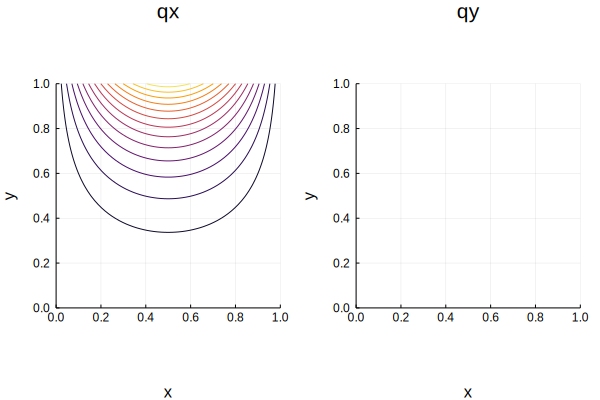

In [78]:
i_x_b, i_y_b = indices(u0,1,interior=false) # plot the boundary values, too
j_x_b, j_y_b = indices(u0,2,interior=false)
p1 = contour(xedgex.(i_x_b),yedgex.(j_x_b),transpose(uarray[end].qx[i_x_b,j_x_b]),legend=false,title="qx")
p2 = contour(xedgey.(i_y_b),yedgey.(j_y_b),transpose(uarray[end].qy[i_y_b,j_y_b]),legend=false,title="qy")
plot(p1,p2,layout=(1,2),xlabel="x",ylabel="y",ratio=1,xlim=(xedgex(1),xedgex(NX+1)),ylim=(yedgey(1),yedgey(NY+1)))

Exact solution evaluated on edge data

In [79]:
f2n(x,y,t,n) = 2/π*sin(π*x)*(-1)^n*n/(n^2+1)*exp(-ν*(n^2+1)*π^2*t)*sin(n*π*y) 

f2n (generic function with 1 method)

In [80]:
texact = tarray[end]
uexact = EdgeData(u0)
# make sure to evaluate on boundary edges...
i_x_b, i_y_b = indices(uexact,1,interior=false)
j_x_b, j_y_b = indices(uexact,2,interior=false)
nterms = 10
for j in j_x_b, i in i_x_b
    x, y = xedgex(i),yedgex(j)
    uexact.qx[i,j] = sin(π*x)*sinh(π*y)/sinh(π)
    for n = 1:nterms
        uexact.qx[i,j] += f2n(x,y,texact,n)     
    end
end
for j in j_y_b, i in i_y_b
    x, y = xedgey(i),yedgey(j)
    #uexact.qy[i,j] = sin(π*x)*sinh(π*y)/sinh(π)
    for n = 1:nterms
        #uexact.qy[i,j] += f2n(x,y,texact,n)
    end
end

#### Evaluate the error

In [81]:
norm(uexact-uarray[end])/norm(uexact)

0.002415807149192539

#### Store it for later plotting

In [118]:
push!(Narray,NX)
push!(errarray,norm(uexact-uarray[end])/norm(uexact))

4-element Array{Any,1}:
 0.0006082773504224867
 0.002415807149192539 
 0.00939714498743494  
 0.031277146803991004 

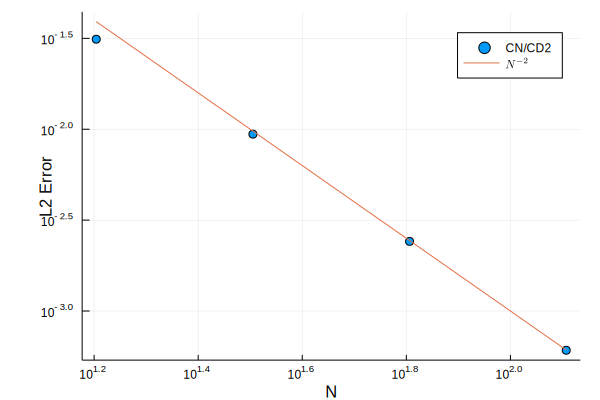

In [126]:
scatter(Narray,errarray,xscale=:log10,yscale=:log10,xlabel="N",ylabel="L2 Error",label="CN/CD2")
plot!(Narray,10*Narray.^(-2),label="\$N^{-2}\$")

#### If node data were used instead of edge data

Plotting node data

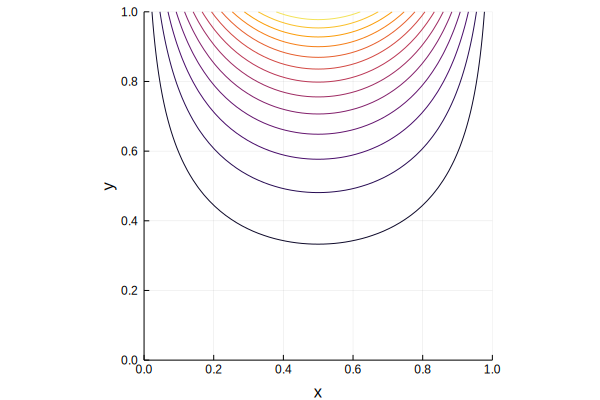

In [62]:
i_n_b = indices(uexact,1,interior=false)
j_n_b = indices(uexact,2,interior=false)
p1 = contour(xnode.(i_n_b),ynode.(j_n_b),transpose(uarray[end][i_n_b,j_n_b]),legend=false)
plot(p1,xlabel="x",ylabel="y",ratio=1,xlim=(xnode(1),xnode(NX+1)),ylim=(ynode(1),ynode(NY+1)))

Exact solution evaluated on node data

In [60]:
texact = tarray[end]
uexact = NodeData(u0)
i_n_b = indices(uexact,1,interior=false)
j_n_b = indices(uexact,2,interior=false)
nterms = 10
for j in j_n_b, i in i_n_b
    x, y = xnode(i),ynode(j)
    uexact[i,j] = sin(π*x)*sinh(π*y)/sinh(π)
    for n = 1:nterms
        uexact[i,j] += f2n(x,y,texact,n)     
    end
end

In [61]:
norm(uexact-uarray[end])

2.9084079658653796e-5

Plot the error distribution

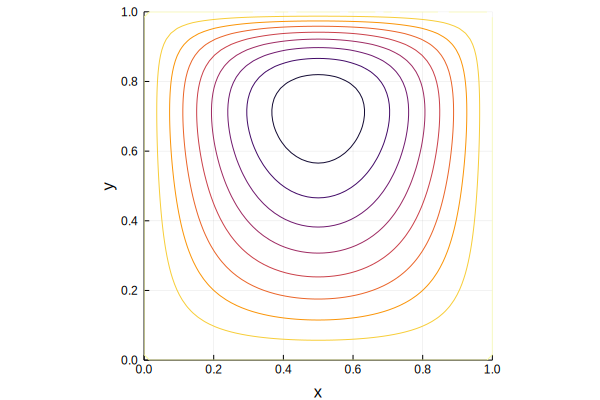

In [67]:
p1 = contour(xnode.(i_n_b),ynode.(j_n_b),transpose(uexact[i_n_b,j_n_b]-uarray[end][i_n_b,j_n_b]),legend=false,levels=range(-1e-4,1e-4,length=31))
plot(p1,xlabel="x",ylabel="y",ratio=1,xlim=(xnode(1),xnode(NX+1)),ylim=(ynode(1),ynode(NY+1)))